In [1]:
using LinearAlgebra
using QuantumOptics
using DifferentialEquations
using SparseArrays
using Arpack
using PyPlot
using Distributions
using ForwardDiff
using NLsolve
using Roots
using Cubature
using QuadGK

In [2]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 12;
rcParams["font.sans-serif"] = "Arial";

The goal here is, for a few laser implementations of interest, to solve the Langevin equations:
\begin{equation}
\dot{S}_{33} = \Lambda - \left[ \gamma_{||} + R_{sp}(n) n \right]S_{33} + F_{33}
\end{equation}
for the inversion, and
\begin{equation}
\dot{n} = \left[R_{sp}(n)S_{33} - \kappa(n) \right]n + F_{n}
\end{equation}
for the photon number. 

Here, $\Lambda$ is the pumping rate, $\gamma_{||}$ is the inversion relaxation rate. The cavity-mode spontaneous emission rate is given by $R_{sp}(n) = \frac{2g^2}{\gamma_{\perp}}\frac{\gamma_{\perp}^2}{\gamma_{\perp}^2 + (\omega(n)-\omega_a)^2}$, with $\frac{2g^2}{\gamma_{\perp}}$ the spontaneous emission rate on resonance ($R_{sp}(\omega_a) \sim c\sigma_{st}/V$), $\gamma_{\perp}$ the polarization relaxation time, $\omega_a$ the atomic frequency, and $\omega(n)$ the nonlinear cavity frequency.

The forces have zero mean, and their diffusion coefficients are given by:
\begin{equation}
\langle 2D_{n,n}\rangle = \langle R_{sp}(n)nS_{33}\rangle + \langle \kappa(n)n\rangle,
\end{equation}

\begin{equation}
\langle 2D_{33,33}\rangle = \Lambda + \gamma_{||}\langle S_{33}\rangle + \langle R_{sp}(n)nS_{33}\rangle,
\end{equation}
and
\begin{equation}
\langle 2D_{33,n}\rangle = \langle 2D_{n,33}\rangle = -\langle R_{sp}(n) nS_{33} \rangle.
\end{equation}

To find the gross statistics of the cavity field, we want $\langle n \rangle$, as well as $(\delta n)^2$. To get this, take $n = \langle n \rangle + \delta n$ and $S_{33} = D + \delta S$. It follows from these definitions that $(\Delta n)^2 = \langle (\delta n)^2 \rangle$ and the mean value of $n$ is given simply by $\langle n \rangle$. Solving the equations for the mean values yields
\begin{equation}
D = \frac{\Lambda}{\gamma_{||} + R_{sp}(\langle n \rangle)\langle n \rangle} \equiv \frac{D_0}{1 + \frac{R_{sp}(\langle n \rangle)}{\gamma_{||}}\langle n \rangle}
\end{equation}
and
\begin{equation}
\frac{D_0 R_{sp}(\langle n \rangle)}{1 + \frac{R_{sp}(\langle n \rangle)}{\gamma_{||}}\langle n \rangle} = \kappa(\langle n \rangle).
\end{equation}
This implicit equation for the photon number can also be recast as (suppressing dependence on $\langle n \rangle$ for clarity):
\begin{equation}
\langle n \rangle = \frac{\Lambda}{\kappa} - \frac{\gamma_{||}}{R_{sp}}.
\end{equation}

Note that therefore, the diffusion coefficients may be written as:
\begin{equation}
\langle 2D_{n,n}\rangle = 2\langle \kappa(n)n\rangle,
\end{equation}

\begin{equation}
\langle 2D_{33,33}\rangle = 2\langle \kappa(n)(n+n_s)\rangle,
\end{equation}

\begin{equation}
\langle 2D_{33,n}\rangle = \langle 2D_{n,33}\rangle = -\langle \kappa n \rangle.
\end{equation}
Here, we've introduced the saturation photon number $n_s = (R_{sp}/\gamma_{||})^{-1}$.

For the fluctuations, we get the set of equations (with $\langle n \rangle \rightarrow n$ for clarity)
\begin{equation}
\begin{pmatrix}
\dot{\delta S} \\
\dot{\delta n}
\end{pmatrix} = \begin{pmatrix}
-\left( \gamma_{||} + R_{sp}(n)n \right) && -\left(R_{sp}(n) + n R'_{sp}(n) \right)D \\
R_{sp}n && (DR'_{sp}(n)-\kappa'(n))n
\end{pmatrix}
\begin{pmatrix}
\delta S \\
\delta n
\end{pmatrix} + 
\begin{pmatrix}
F_{33} \\
F_n
\end{pmatrix},
\end{equation}
which can be expressed simply as $\dot{\delta V} = M\delta V + F$. Fourier transforming, one obtains: $-i\omega\delta V(\omega) = M\delta V(\omega) + F(\omega)$ which yields the solution $\delta V(\omega) = -[M+i\omega]^{-1}F(\omega) \equiv K(\omega)F(\omega)$. The photon number uncertainty is given simply by the spectrum
\begin{equation}
(\Delta n)^2 = \frac{1}{\pi}\int\limits_0^{\infty} d\omega ~ \langle \delta n(\omega) \delta n(-\omega) \rangle.
\end{equation}

In the cells below, we implement functions to calculate the intensity-dependent loss (and gain), and use it to calculate the cavity number noise spectrum.

Note that a calculation of photon statistics for a Fock laser, with a sharp loss (and potentially sharp gain) requires specification of the nonlinear cavity (cavity_params), the properties of the loss assuming Fano transmission losses (loss_params), and the properties of the gain medium (gain_params). The gain is assumed to be a four-level gain medium with rapidly decaying upper-pump and lower lasing levels, as well as non-depleted ground level. 

The cell below calculates gain and loss (assuming the loss comes from transmission through a Fano mirror).

In [3]:
## Some constants and units.

c0 = 3.0e8;
ħ = 1.05e-34;
ϵ0 = 8.85e-12;
evtorads = 1.52e15;
kWcm2 = 1e7;

## This calculates the in-principle nonlinear gain (the gain depends on the detuning of the laser transition
## and the cavity

function gain(n,ω,gain_params)
    
    ωa = gain_params[1];
    γ_perp = gain_params[2];
    γ_par = gain_params[3];
    R_sp = gain_params[4];
    Λ = gain_params[5];
    
    Δ = ω - ωa;
    D0 = Λ/γ_par;
    
    Rn = R_sp * (γ_perp^2 / (γ_perp^2 + Δ^2));
    D = D0/(1+(Rn/γ_par)*n);
    
    g = Rn*D;
    
    return g
end

## This calculates the number-dependent cavity frequency

function ωn(n,cavity_params)
    
    ω = cavity_params[1];
    β = cavity_params[2];
    
    freq = ω*(1-2*β*n);
    
    return freq
end

## This calculates the frequency-dependent transmission for a mirror with
## a Fano transmission profile as a function of the direct transmission and reflection
## as well as the frequency width of the mirror.

function fano_transmission(ω,loss_params)
    
    ωd = loss_params[1];
    td = loss_params[2];
    rd = loss_params[3];
    γd = loss_params[4];
    
    Δ = ωd - ω;
    
    num = (td*Δ)^2 + (rd*(γd/2))^2 - 2*(γd/2)*Δ*real(td*rd);
    denom = Δ^2 + (γd/2)^2;
    
    T = num / denom;
    
    return T
end

function fano_loss(n,cavity_params,loss_params)
    
    ω = cavity_params[1];
    β = cavity_params[2];
    v = cavity_params[3];
    l = cavity_params[4];
    
    T_fano = fano_transmission(ω*(1-2*β*n),loss_params);
    fsr = v/(2*l);
    loss = fsr*T_fano;
    
    return loss
end

fano_loss (generic function with 1 method)

The cells below implement the calculation of $\delta n(\omega)$ and the number noise spectrum, following the derivation provided in the first cell. 

Note that many of these functions take a parameter "sharp": if it is set to 1, then the loss and gain derivative terms are included into the calculation. If sharp = 0, the calculation pretends the loss doesn't depend on photon number and the gain is simply saturable gain. 

In [8]:
## This calculates the matrix (M + iω)^-1 detailed in the top of this notebook.

function langevin_matrix(Ω,n,gain_params,loss_params,cavity_params,sharp=1)
    # sharp = 1 corr. to sharp loss, sharp = 0 corr. to lin. loss
    ωa = gain_params[1];
    γ_perp = gain_params[2];
    γ_par = gain_params[3];
    R_sp = gain_params[4];
    Λ = gain_params[5];
    
    ωd = loss_params[1];
    td = loss_params[2];
    rd = loss_params[3];
    γd = loss_params[4];    
    
    ω = cavity_params[1];
    β = cavity_params[2];
    v = cavity_params[3];
    l = cavity_params[4];
    
    ω_nl = ωn(n,cavity_params);
    
    Rn = R_sp * (γ_perp^2 / (γ_perp^2 + (ω_nl-ωa)^2));
    D0 = Λ/γ_par;
    D = D0/(1+(Rn/γ_par)*n); 
    
    κn = (v/(2*l))*fano_transmission(ωn(n,cavity_params),loss_params);
    
    nl_gain_func(n) = R_sp * (γ_perp^2 / (γ_perp^2 + (ωn(n,cavity_params)-ωa)^2));
    nl_loss_func(n) = fano_loss(n,cavity_params,loss_params);
    
    Rn_prime = ForwardDiff.derivative(nl_gain_func,n);
    κn_prime = ForwardDiff.derivative(nl_loss_func,n);
    
    M = 1.0im*zeros(2,2);
    
    if sharp == 1
        M[1,1] = -(γ_par + Rn*n) + 1im*Ω;
        M[1,2] = -(Rn + n*Rn_prime)*D;
        M[2,1] = Rn*n;
        M[2,2] = n*(D*Rn_prime - κn_prime) + 1im*Ω;
    else
        M[1,1] = -(γ_par + Rn*n) + 1im*Ω;
        M[1,2] = -Rn*D;
        M[2,1] = Rn*n;
        M[2,2] = 1im*Ω; 
    end
    
    K = -inv(M);
    
    return K
end

## This calculates the matrix of diffusion coefficients.

function diffusion_matrix(n,gain_params,loss_params,cavity_params)
    
    ωa = gain_params[1];
    γ_perp = gain_params[2];
    γ_par = gain_params[3];
    R_sp = gain_params[4];
    Λ = gain_params[5];
    
    ωd = loss_params[1];
    td = loss_params[2];
    rd = loss_params[3];
    γ = loss_params[4];    
    
    ω = cavity_params[1];
    β = cavity_params[2];
    v = cavity_params[3];
    l = cavity_params[4];
    
    ω_nl = ωn(n,cavity_params);
    
    Rn = R_sp * (γ_perp^2 / (γ_perp^2 + (ω_nl-ωa)^2));
    # println(Rn/R_sp)
    D0 = Λ/γ_par;
    D = D0/(1+(Rn/γ_par)*n); 
    
    g = gain(n,ωn(n,cavity_params),gain_params);
    κn = fano_loss(n,cavity_params,loss_params);
    
    diffusion = 1.0im*zeros(2,2);
    
    diffusion[1,1] = Λ + γ_par*D + g*n;
    diffusion[1,2] = -g*n;
    diffusion[2,1] = diffusion[1,2];
    diffusion[2,2] = g*n + κn*n;
    
    return diffusion
end

## This calculates the cavity number noise spectrum.

function noise_spec(Ω,n,gain_params,loss_params,cavity_params,sharp=1)
    
    K = langevin_matrix(Ω,n,gain_params,loss_params,cavity_params,sharp);
    Kn = K[2,1:2];

    diffusion = diffusion_matrix(n,gain_params,loss_params,cavity_params);
    
    Sω = (1/pi)*(K[2,1]*diffusion[1,1]*conj(K[2,1]) +
        K[2,1]*diffusion[1,2]*conj(K[2,2]) +
        K[2,2]*diffusion[2,1]*conj(K[2,1]) +
        K[2,2]*diffusion[2,2]*conj(K[2,2]));
    
    return Sω
end

## This finds the mean number of photons, solving the steady-state condition presented at the top of the notebook.

function find_nbar(gain_params,loss_params,cavity_params,ninit=1e-7)
    
    gain_loss_diff(n) = gain(n,ωn(n,cavity_params),gain_params) - fano_loss(n,cavity_params,loss_params);
    nbar = find_zero(gain_loss_diff,ninit)
    
    return nbar
end

## This integrates the number noise spectrum to get the variance in cavity photon number, and normalizes
## it to the mean number to return also the Fano factor.

function langevin_stats(gain_params,loss_params,cavity_params,sharp=1,ninit=1e-7)
    # Will solve for n, and if finite solution, do the rest.

    nbar = find_nbar(gain_params,loss_params,cavity_params,ninit);
    
    if nbar > 0
        dn2 = real(quadgk((Ω -> noise_spec(Ω,nbar,gain_params,loss_params,cavity_params,sharp)), 
        0,1e15; rtol=1e-4)[1]);
        fano = dn2/nbar;
    else
        nbar = 0;
        dn = 0;
        fano = 0;
    end

    return nbar, dn2, fano
end

langevin_stats (generic function with 3 methods)

This last function calculates a few useful intermediate quantities associated with the steady state. They are: (1) the mean cavity photon number (2) the nonlinear frequency shift, normalized to the cavity frequency (3) the gain rate in the steady state (4) the loss rate in the steady state (5) the magnitude of the stimulated emission rate in the steady-state (e.g., the magnitude of gain saturation) (6) the derivative of the loss at steady-state, and (7) the derivative of the gain-loss ratio at steady state, which determines the magnitude of the photon variance (Eq. (7) of main text). 

In [9]:
function langevin_intermediate_qtys(gain_params,loss_params,cavity_params,sharp=1,ninit=1e-7)
    # Will solve for n, and if finite solution, do the rest.
    
    ωa = gain_params[1];
    γ_perp = gain_params[2];
    γ_par = gain_params[3];
    R_sp = gain_params[4];
    Λ = gain_params[5];
    
    ωd = loss_params[1];
    td = loss_params[2];
    rd = loss_params[3];
    γ = loss_params[4];    
    
    ω = cavity_params[1];
    β = cavity_params[2];
    v = cavity_params[3];
    l = cavity_params[4];
    
    nbar = find_nbar(gain_params,loss_params,cavity_params,ninit);
    ω_nbar = ωn(nbar,cavity_params);
    g_nbar = gain(nbar,ωn(nbar,cavity_params),gain_params);
    κ_nbar = fano_loss(nbar,cavity_params,loss_params);
    
    D0 = Λ/γ_par;
    
    nl_gain_func(n) = R_sp * (γ_perp^2 / (γ_perp^2 + (ωn(n,cavity_params)-ωa)^2));
    nl_loss_func(n) = fano_loss(n,cavity_params,loss_params);
    
    sat_gain_func(n) = nl_gain_func(n) * D0 / (1 + (nl_gain_func(n)/γ_par)*n);
    gain_loss_ratio_func(n) = sat_gain_func(n)/fano_loss(n,cavity_params,loss_params);
    gain_loss_ratio_func_flat(n) = sat_gain_func(n)/κ_nbar;
    
    Rn_prime = ForwardDiff.derivative(nl_gain_func,nbar);
    κn_prime = ForwardDiff.derivative(nl_loss_func,nbar);
    
    if sharp == 1
        gl_prime = ForwardDiff.derivative(gain_loss_ratio_func,nbar);
    else
        gl_prime = ForwardDiff.derivative(gain_loss_ratio_func_flat,nbar);
    end

    results = [nbar, ω_nbar/ω, g_nbar, κ_nbar, R_sp*nbar, κn_prime, gl_prime];
    return results
    
end

langevin_intermediate_qtys (generic function with 3 methods)

## Example of the framework for a solid-state laser gain medium

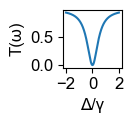

The magnitude of κ is 8.467741935483871e-5
The magnitude of κ/γ is 0.008467741935483872


In [10]:
## Gain medium parameters for Nd:YAG.
ω_gain = (1240/1064)*evtorads;
γ_perp_gain = 9.98e11;
γ_par_gain = 4.34e3;
σ_st_gain = 2.8e-23; # m^2;
σ_abs_gain = 7.7e-24;
n_gain = 1.82;
density_gain = 1.38e26 # 1% atomic doping (per m^3)

## Cavity mode properties for a mm-scale open cavity with a TEM00 mode. The β parameter was calculated by
## an overlap integral.
δ_ca = 0*γ_perp_gain; # cavity-atom detuning
ω_cav = ω_gain + δ_ca;
L_cav = 1e-3;
R_mode = 40e-6;
V_mode = (pi*(R_mode)^2)*L_cav;
v_cav = c0;
β_cav = 5e-18;

cavity_params = [ω_cav, β_cav, v_cav, L_cav];

# Spontaneous emission rate into the mode
Rsp_gain = (c0/n_gain)*σ_st_gain/V_mode;

## Pumping parameters for the gain.
I_inc = 0.2*kWcm2; 
γ41_gain = (σ_abs_gain*I_inc)/(ħ*ω_gain);
fill = 0.5;
L_gain = fill*L_cav;
N_gain = density_gain * (pi*(R_mode)^2) * L_gain; # assuming transverse pump fully inside gain
Λ_gain = N_gain*γ41_gain;

gain_params = [ω_gain, γ_perp_gain, γ_par_gain, Rsp_gain, Λ_gain];

## Fano loss parameters
td = 1;
rd = sqrt(1-td^2);
γd = (1e-2)*ω_cav; 
δ_cm = -1*0.001*γd;
ωd = ω_cav + δ_cm;

loss_params = [ωd,td,rd,γd];
figure(figsize=(0.75,0.75))
plot([(ww-ωd)/γd for ww=(ωd-2*γd):(γd/1000):(ωd+2*γd)],[fano_transmission(ww,loss_params) for ww=(ωd-2*γd):(γd/1000):(ωd+2*γd)])
ylabel("T(ω)")
xlabel("Δ/γ")
println("The magnitude of κ is $((v_cav*td^2/2/L_cav)/ω_cav)")
println("The magnitude of κ/γ is $((v_cav*td^2/2/L_cav)/ω_cav / (γd / ω_cav))")

Let's plot a gain-loss curve for a given pump value.

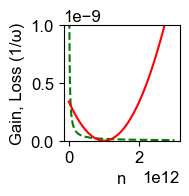

PyObject Text(25.000000000000007, 0.5, 'Gain, Loss (1/ω)')

In [11]:
figure(figsize=(1.5,1.5))
naxis_vals = [nn for nn=0:1e8:0.3e13];
plot(naxis_vals, [gain(nn,ωn(nn,cavity_params),gain_params) for nn in naxis_vals]/ω_gain,linestyle="--", color="g")
plot(naxis_vals, [fano_loss(nn,cavity_params,loss_params) for nn in naxis_vals]/ω_gain,linestyle="-", color="r")
ylim(0,1e-9)
xlabel("n")
ylabel("Gain, Loss (1/ω)") 

We can calculate the mean, variance, and Fano factor for the two steady-states here. They are the first, second, and third outputs of the line below, respectively. Make sure to set the guess for the nonlinear solver for the mean photon number as something pretty close to the intersection points. 

In [12]:
langevin_stats(gain_params,loss_params,cavity_params,1,1e9)

(5.340891786422269e10, 6.086918096571741e10, 1.1396819744683906)

In [13]:
langevin_stats(gain_params,loss_params,cavity_params,1,2e12)

(1.199730786934973e12, 9.21934399045235e10, 0.07684510634261194)

In [14]:
langevin_stats(gain_params,loss_params,cavity_params,0,2e12)

(1.199730786934973e12, 1.1997615797304746e12, 1.0000256664210314)

According to the above three lines: the first steady state has 13% more noise than the shot noise level, the second has nearly 95% less. If the loss weren't sharp, the second would be more or less at the shot noise level. The cell below calculates the noise spectrum for the two steady states with and without sharpness, as in Fig. 4 of the main text.

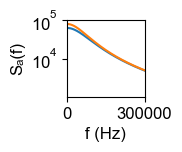

In [25]:
nbar = find_nbar(gain_params,loss_params,cavity_params,1e9)
figure(figsize=(1,1))
fvals = [Ω/2/pi for Ω = 0:1e2:(2*pi*1e6)];
semilogy(fvals,[noise_spec(2*pi*ff,nbar,gain_params,loss_params,cavity_params,0) for ff in fvals])
semilogy(fvals,[noise_spec(2*pi*ff,nbar,gain_params,loss_params,cavity_params,1) for ff in fvals])
xlabel("f (Hz)")
ylabel("Sₐ(f)")
xlim(0,3e5)
ylim(1e3)
xticks([0,3*10^5])
yticks([1e4,1e5]);

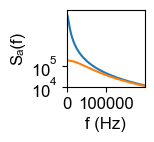

In [27]:
nbar = find_nbar(gain_params,loss_params,cavity_params,2e12)
figure(figsize=(1,1))
fvals = [Ω/2/pi for Ω = 0:1e2:(2*pi*1e6)];
semilogy(fvals,[noise_spec(2*pi*ff,nbar,gain_params,loss_params,cavity_params,0) for ff in fvals])
semilogy(fvals,[noise_spec(2*pi*ff,nbar,gain_params,loss_params,cavity_params,1) for ff in fvals])
xlabel("f (Hz)")
ylabel("Sₐ(f)")
xlim(0,2e5)
ylim(1e4)
xticks([0,10^5])
yticks([10^4,10^5]);

The last cell repeats these calculations for a larger pump level.

In [39]:
## Pumping parameters for the gain.
I_inc = 0.9*kWcm2; 
γ41_gain = (σ_abs_gain*I_inc)/(ħ*ω_gain);
fill = 0.5;
L_gain = fill*L_cav;
N_gain = density_gain * (pi*(R_mode)^2) * L_gain;
Λ_gain = N_gain*γ41_gain;

gain_params = [ω_gain, γ_perp_gain, γ_par_gain, Rsp_gain, Λ_gain];

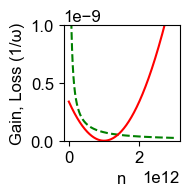

PyObject Text(25.000000000000007, 0.5, 'Gain, Loss (1/ω)')

In [40]:
figure(figsize=(1.5,1.5))
naxis_vals = [nn for nn=0:1e8:0.3e13];
plot(naxis_vals, [gain(nn,ωn(nn,cavity_params),gain_params) for nn in naxis_vals]/ω_gain,linestyle="--", color="g")
plot(naxis_vals, [fano_loss(nn,cavity_params,loss_params) for nn in naxis_vals]/ω_gain,linestyle="-", color="r")
ylim(0,1e-9)
xlabel("n")
ylabel("Gain, Loss (1/ω)") 

In [43]:
langevin_stats(gain_params,loss_params,cavity_params,1,2e12)

(1.3931786980212341e12, 1.7229191905086877e11, 0.12366821233742607)

In [42]:
langevin_stats(gain_params,loss_params,cavity_params,0,2e12)

(1.3931786980212341e12, 1.3932844948288682e12, 1.0000759391510825)

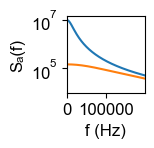

In [45]:
nbar = find_nbar(gain_params,loss_params,cavity_params,2e12)
figure(figsize=(1,1))
fvals = [Ω/2/pi for Ω = 0:1e2:(2*pi*1e6)];
semilogy(fvals,[noise_spec(2*pi*ff,nbar,gain_params,loss_params,cavity_params,0) for ff in fvals])
semilogy(fvals,[noise_spec(2*pi*ff,nbar,gain_params,loss_params,cavity_params,1) for ff in fvals])
xlabel("f (Hz)")
ylabel("Sₐ(f)")
xlim(0,2e5)
ylim(1e4)
xticks([0,10^5])
yticks([10^5,10^7]);

Here: there is only one steady state, it has about 90% less noise than the coherent state integrated over all frequencies, and about 99% lower at low frequencies.